##Loading Data

In [0]:
from pyspark.sql import SparkSession
#initializing Spark Session
spark = SparkSession.builder.appName("AirbnbDataAnalysis").getOrCreate() 

In [0]:
file_path= "/FileStore/tables/listings.csv"
#load csv file
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(5)

+-----+--------------------+-------+---------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------+
|   id|                name|host_id|host_name|neighbourhood_group|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|license|
+-----+--------------------+-------+---------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------+
|13913|Holiday London DB...|  54730|    Alina|               null|           Islington|51.56861|  -0.1127|   Private room|   59|             1|               47| 17-11-2024|             0.27

## Data Preprocessing

In [0]:
#schema check
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: double (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- number_of_reviews_ltm: integer (nullable = true)
 |-- license: integer (nullable = true)



**we can see that `host_id`,`reviews_per_month`,`price`, `latitude` and `longitude` should be numerical format, but they are stored as strings**

In [0]:
#Converting data types
from pyspark.sql.functions import col
df = df.withColumn("host_id", col("host_id").cast("int")) \
       .withColumn("latitude", col("latitude").cast("double")) \
       .withColumn("longitude", col("longitude").cast("double")) \
       .withColumn("price", col("price").cast("float")) \
       .withColumn("reviews_per_month", col("reviews_per_month").cast("float"))
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: float (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: float (nullable = true)
 |-- calculated_host_listings_count: double (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- number_of_reviews_ltm: integer (nullable = true)
 |-- license: integer (nullable = true)



In [0]:
#Handling missing values
from pyspark.sql.functions import count,when
#counting missing values in each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------+
| id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|license|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------+
|  0|  43|    572|      569|              95197|          322|     322|      563|      367|32634|           314|              373|      24894|            24843|                           315|             313|                  563|  95447|
+---+----+-------+---------+----------------

In [0]:
#removing duplicates
df=df.dropDuplicates()

**Feature Engineering**

In [0]:
cols=["id", "name", "host_id", "neighbourhood", "room_type", "price", "minimum_nights", "number_of_reviews"]
df=df.select(cols)
df.head(6)

Out[28]: [Row(id='17402', name='Very Central Modern 3-Bed/2 Bath By Oxford St W1', host_id=67564, neighbourhood='Westminster', room_type='Entire home/apt', price=501.0, minimum_nights=3, number_of_reviews='56'),
 Row(id='31036', name='Bright  compact 1 Bedroom Apartment Brick Lane', host_id=133271, neighbourhood='Tower Hamlets', room_type='Entire home/apt', price=105.0, minimum_nights=3, number_of_reviews='123'),
 Row(id='24328', name='Battersea live/work artist house', host_id=41759, neighbourhood='Wandsworth', room_type='Entire home/apt', price=225.0, minimum_nights=2, number_of_reviews='94'),
 Row(id='33332', name='Beautiful Ensuite Richmond-upon-Thames borough', host_id=144444, neighbourhood='Richmond upon Thames', room_type='Private room', price=140.0, minimum_nights=2, number_of_reviews='19'),
 Row(id='13913', name='Holiday London DB Room Let-on going', host_id=54730, neighbourhood='Islington', room_type='Private room', price=59.0, minimum_nights=1, number_of_reviews='47'),
 Row(

In [0]:
#identifying null values
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+---+----+-------+-------------+---------+-----+--------------+-----------------+
| id|name|host_id|neighbourhood|room_type|price|minimum_nights|number_of_reviews|
+---+----+-------+-------------+---------+-----+--------------+-----------------+
|  0|  32|    560|          310|      355|32622|           302|              361|
+---+----+-------+-------------+---------+-----+--------------+-----------------+



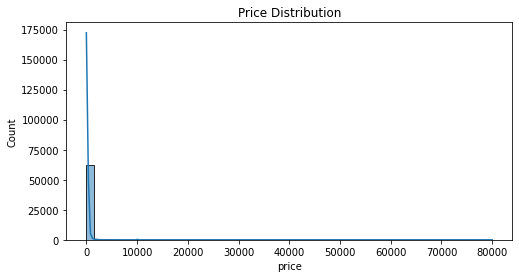

In [0]:
#checking data whether normally distributed
import seaborn as sns
import matplotlib.pyplot as plt

# Example for 'price' column
plt.figure(figsize=(8,4))
sns.histplot(df.toPandas()["price"], bins=50, kde=True)  # Convert PySpark DF to Pandas for plotting
plt.title("Price Distribution")
plt.show()


1. If the histogram is **bell-shaped**, the data is likely normally distributed.

2. If it’s skewed **left** or **right**, the data is not normally distributed.

The data has been skewed `left` in our case. Hence it is not normally distributed.

In [0]:
print(df.dtypes)

[('id', 'string'), ('name', 'string'), ('host_id', 'int'), ('neighbourhood', 'string'), ('room_type', 'string'), ('price', 'float'), ('minimum_nights', 'int'), ('number_of_reviews', 'string')]


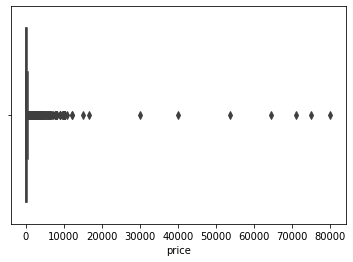

In [0]:
#checking outliers
sns.boxplot(x=df.toPandas()["price"])
plt.show()

**So many extreme values**

In [0]:
df = df.fillna({"number_of_reviews": 0, "minimum_nights": 1})
df.head(5)


Out[36]: [Row(id='17402', name='Very Central Modern 3-Bed/2 Bath By Oxford St W1', host_id=67564, neighbourhood='Westminster', room_type='Entire home/apt', price=501.0, minimum_nights=3, number_of_reviews='56'),
 Row(id='31036', name='Bright  compact 1 Bedroom Apartment Brick Lane', host_id=133271, neighbourhood='Tower Hamlets', room_type='Entire home/apt', price=105.0, minimum_nights=3, number_of_reviews='123'),
 Row(id='24328', name='Battersea live/work artist house', host_id=41759, neighbourhood='Wandsworth', room_type='Entire home/apt', price=225.0, minimum_nights=2, number_of_reviews='94'),
 Row(id='13913', name='Holiday London DB Room Let-on going', host_id=54730, neighbourhood='Islington', room_type='Private room', price=59.0, minimum_nights=1, number_of_reviews='47'),
 Row(id='15400', name='Bright Chelsea  Apartment. Chelsea!', host_id=60302, neighbourhood='Kensington and Chelsea', room_type='Entire home/apt', price=120.0, minimum_nights=4, number_of_reviews='96')]

In [0]:
 df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
 df.show()

+-----+--------------------+-------+--------------------+---------------+-----+--------------+-----------------+
|   id|                name|host_id|       neighbourhood|      room_type|price|minimum_nights|number_of_reviews|
+-----+--------------------+-------+--------------------+---------------+-----+--------------+-----------------+
|17402|Very Central Mode...|  67564|         Westminster|Entire home/apt|501.0|             3|               56|
|41870|Room in relaxed f...| 182993|      Waltham Forest|   Private room| null|             2|                2|
|31036|Bright  compact 1...| 133271|       Tower Hamlets|Entire home/apt|105.0|             3|              123|
|38950|Room 1 Large Doub...| 167107|            Haringey|   Private room| 55.0|             1|                1|
|42010|You Will Save Mon...| 157884|              Barnet|   Private room| 65.0|             2|              604|
|24328|Battersea live/wo...|  41759|          Wandsworth|Entire home/apt|225.0|             2|  

##Data Exploration & Analysis

In [0]:
#checking basic statistics
df.describe().show()

+-------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+-----------------+-----------------+
|summary|                  id|                name|             host_id|      neighbourhood|         room_type|             price|   minimum_nights|number_of_reviews|
+-------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+-----------------+-----------------+
|  count|               95424|               95392|               94864|              95114|             95069|             62802|            95424|            95424|
|   mean|5.770480124582083...| 2.419262616459144E8|1.9381480801724574E8| 51.513505517880006|127.67537839255122|206.61467787650074|5.589757293762576|19.97991263624336|
| stddev|5.304268640244991...|2.0786067934960383E8|2.0075356728620583E8|0.05830548053115835|114.44250701265062| 774.6170449673041|23.23442670458596|47.78966119446791

### Data Visualization

**Top 4 Room Types**

Columns: Index(['room_type', 'count'], dtype='object')


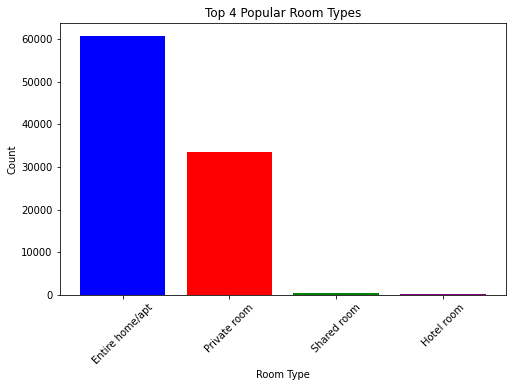

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas only if it's a PySpark DataFrame
if not isinstance(df, pd.DataFrame):
    df = df.toPandas()

# Check and fix column names
print("Columns:", df.columns)  # Debugging step

if "count" not in df.columns:
    df = df.groupby("room_type").size().reset_index(name="count")  # Aggregate if missing

# Ensure count is numeric
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0)

# Select only the top 4 room types
df_top4 = df.nlargest(4, "count")  # Select top 4 based on count

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(df_top4["room_type"], df_top4["count"], color=["blue", "red", "green", "purple"])
plt.xlabel("Room Type")
plt.ylabel("Count")
plt.title("Top 4 Popular Room Types")
plt.xticks(rotation=45)  
plt.show()